# CSE527 Homework 4
**Due date: 23:59 on Nov 6, 2020 (Friday)**

---
In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

## Local Machine Prerequisites
---
Since we are using Google Colab, all the code is run on the server environment where lots of libraries or packages have already been installed. In case of missing 
 libraries or if you want to install them in your local machine, below are the links for installation.
* **Install Python 3.6.9**: https://www.python.org/downloads/ or use Anaconda (a Python distribution) at https://docs.continuum.io/anaconda/install/. Below are some materials and tutorials which you may find useful for learning Python if you are new to Python.
  - https://docs.python.org/3.6/tutorial/index.html
  - https://www.learnpython.org/
  - https://docs.opencv.org/4.1.2/d6/d00/tutorial_py_root.html
  - http://www.scipy-lectures.org/advanced/image_processing/index.html


* **Install Python packages**: install Python packages: `numpy`, `matplotlib`, `opencv-python` using pip, for example:
```
pip install numpy matplotlib opencv-python
``` 
	Note that when using “pip install”, make sure that the version you are using is python3. Below are some commands to check which python version it uses in you machine. You can pick one to execute:
  
```
    pip show pip
    pip --version
    pip -V
```

In case of the wrong version, use `pip3` for python3 explictly.

* **Install Jupyter Notebook**: follow the instructions at http://jupyter.org/install.html to install Jupyter Notebook and familiarize yourself  with it. *After you have installed Python and Jupyter Notebook, please open this notebook file with your Jupyter Notebook and do your homework there.*


## Description
---
This project is an introduction to deep learning tools for computer vision. You will design and train deep convolutional networks for scene recognition using [PyTorch](http://pytorch.org).

Remember Homework 3: Scene recognition with bag of words. You worked hard to design a bag of features representations that achieved 40% to 45% accuracy (most likely) on 16-way scene classification. We're going to attack the same task with deep learning and get higher accuracy. Training from scratch won't work quite well due to the insufficient amount of data, fine-tuning an existing network will work much better than homework 3.

In Problem 1, you will train a deep convolutional network from scratch to recognize scenes. The starter code gives you methods to load data and display them. You will need to define a simple network architecture and add jittering, normalization, and regularization to increase recognition accuracy to 50, 60, or perhaps 70%. Unfortunately, we only have 2,400 training examples so it doesn't seem possible to train a network from scratch which outperforms hand-crafted features

For Problem 2 you will instead fine-tune a pre-trained deep network to achieve about 85% accuracy on the task. We will use the pre-trained AlexNet network which was not trained to recognize scenes at all. 

These two approaches represent the most common approaches to recognition problems in computer vision today -- train a deep network from scratch if you have enough data (it's not always obvious whether or not you do), and if you cannot then instead fine-tune a pre-trained network.

There are 2 problems in this homework with a total of 110 points including 10 bonus points. Be sure to read **Submission Guidelines** below. They are important. For the problems requiring text descriptions, you might want to add a markdown block for that.

## Dataset
---
Save the [dataset(click me)](https://drive.google.com/drive/folders/1MZB6tUfe2O0Y3Vx29VQWGtBlwM12YZz9?usp=sharing) into your working folder in your Google Drive for this homework. <br>
Under your root folder, there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data) containing the images.
**Do not upload** the data subfolder before submitting on blackboard due to size limit. There should be only one .ipynb file under your root folder Surname_Givenname_SBUID.

## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.


## Starter Code
---
In the starter code, you are provided with a function that loads data into minibatches for training and testing in PyTorch.

In [3]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# Replace -----/-----/-----/' with the path such that "CSE527-HW4-fall20" is your working directory
%cd '/content/gdrive/My Drive/CV/kandari_srinivas_112713946_HW4'

/content/gdrive/My Drive/CV/kandari_srinivas_112713946_HW4


In [5]:
# import packages here
import cv2
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [6]:
# ==========================================
#    Load Training Data and Testing Data
# ==========================================
class_names = [name[13:] for name in glob.glob('./data/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print("class_names: %s " % class_names)
n_train_samples = 150
n_test_samples = 50


def img_norm(img):
    img_out = img.astype(np.float)
    # normalize img pixels to [-1, 1]
    ##########--WRITE YOUR CODE HERE--##########
    img_out = (img_out - 127.5) / 127.5       #127.5
    ##########-------END OF CODE-------##########
    return img_out
  

def load_dataset(path, img_size, num_per_class=-1, batch_num=1, shuffle=False, augment=False, is_color=False, zero_centered=False, augment_rotate=False):
    data = []
    labels = []
    
    if is_color:
        channel_num = 3
    else:
        channel_num = 1
        
    # read images and resizing
    for id, class_name in class_names.items():
        print("Loading images from class: %s" % id)
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            if is_color:
                img = cv2.imread(filename)
            else:
                img = cv2.imread(filename, 0)
            
            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)
            
            if is_color:
                img = np.transpose(img, [2, 0, 1])
            
            # norm pixel values to [-1, 1]
            data.append(img_norm(img))
    
    #
    # Write your Data Normalization code here
    # norm data to zero-centered
    images = np.array(data)
    print("DAta Length: ", len(data))
    print("Images Shape: ", images.shape)
    if zero_centered:
        pass
        ##########--WRITE YOUR CODE HERE--##########
        
        mean = images.sum() / np.array(images.shape).prod()
        images = images -mean
        data = list(images)
        ##########-------END OF CODE-------##########
    print("MEAN: ", images.mean())
    #
    # Write your Data Augmentation code here
    # mirroring
    if augment:
        pass
        ##########--WRITE YOUR CODE HERE--##########
        data += [cv2.flip(data[i] ,1) for i in range(len(data))]
        labels += labels

    if augment_rotate:
      data += [cv2.rotate(data[i], cv2.ROTATE_90_CLOCKWISE)  for i in range(len(data))]
      labels += labels


        ##########-------END OF CODE-------##########
    print("Data Length: ", len(data))
    # randomly permute (this step is important for training)
    if shuffle:
        bundle = list(zip(data, labels))
        random.shuffle(bundle)
        data, labels = zip(*bundle)
    
    # divide data into minibatches of TorchTensors
    if batch_num > 1:
        batch_data = []
        batch_labels = []
        
        print(len(data))

        print(batch_num)
        
        for i in range(int(len(data) / batch_num)):
            minibatch_d = data[i*batch_num: (i+1)*batch_num]
            minibatch_d = np.reshape(minibatch_d, (batch_num, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))

            minibatch_l = labels[i*batch_num: (i+1)*batch_num]
            batch_labels.append(torch.LongTensor(minibatch_l))
        data, labels = batch_data, batch_labels 
    
    return zip(batch_data, batch_labels)

class_names: {0: 'Flower', 1: 'Bedroom', 2: 'Forest', 3: 'Coast', 4: 'Store', 5: 'Highway', 6: 'LivingRoom', 7: 'Street', 8: 'OpenCountry', 9: 'Office', 10: 'Kitchen', 11: 'Industrial', 12: 'InsideCity', 13: 'Mountain', 14: 'TallBuilding', 15: 'Suburb'} 


In [7]:
k= np.array([[[[2,2], [2,2]], [[2,2], [2,2]]], [[[2,2], [2,2]], [[2,2], [2,2]]]])
k.sum() / np.array(k.shape).prod()
k-1

array([[[[1, 1],
         [1, 1]],

        [[1, 1],
         [1, 1]]],


       [[[1, 1],
         [1, 1]],

        [[1, 1],
         [1, 1]]]])

In [8]:
# load data into size (64, 64)
img_size = (64, 64)
batch_num = 50 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_num=batch_num))
test_num = len(testloader_small)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
DAta Length:  2400
Images Shape:  (2400, 64, 64)
MEAN:  -0.09300219886131526
Data Length:  2400
2400
50
Finish loading 48 minibatches(=50) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from 

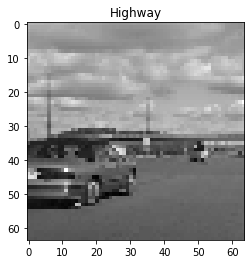

In [ ]:
# show some images
def imshow(img, title):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.title(title)
    plt.show()
img, label = trainloader_small[0][0][12][0], trainloader_small[0][1][12]
label = int(np.array(label))
imshow(img, class_names[label])

## Problem 1: Training a Network From Scratch
Gone are the days of hand-designed features. Now we have end-to-end learning in which a highly non-linear representation is learned for our data to maximize our objective (in this case, 16-way classification accuracy). Let's start with a vanilla version first.


In [ ]:
# ==========================================
#       Define Network Architecture
# ==========================================

class VanillaNet(nn.Module):
    def __init__(self):
        super(VanillaNet,self).__init__()
        
        self.features = torch.nn.Sequential(
            nn.Conv2d(1, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(4, stride=4),   
            # nn.Conv2d(1, 16,  3),
            # nn.ReLU(),
            # nn.MaxPool2d(3, stride=3), #16, 20, 20  
            # nn.Conv2d(16, 16, 3), #16, 18, 18 
            # nn.MaxPool2d(3, stride=3), #16, 6, 6
            # nn.ReLU(),
            # nn.Dropout(0.5)
        )
      
        self.classifier = nn.Sequential(
            # nn.Linear(16 * 6 * 6, 16), 
            # nn.Linear(3600 * 2, 212),
            # nn.Dropout(0.5),
            nn.Linear(3600, 16) 
        )

    def forward(self, x):
        x = self.features(x)  
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x  


# ==========================================
#         Optimize/Train Network
# ==========================================
  
def train_net(net, dataloader, option):  
    loss_func = option['loss']()
    lr = option['lr']
    epoch = option['max_epoch']

    if 'optimizer' in option:
        optimizer = option['optimizer']
    else:
        optimizer = optim.Adam(net.parameters(), lr=lr)

    start_time = time.time()
    net.train()
    
    running_loss = 0.0
    steps = 0
    
    for ep in range(epoch):
        for iteration, (x, y) in enumerate(dataloader):
            batch_x = x.float().to(device)
            batch_y = y.long().to(device)
            outputs = net(batch_x)
            loss = loss_func(outputs, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            steps += 1
            running_loss += loss.item()
            
            if iteration % 5 == 0:
                time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
                print(f'Epoch:{ep:2d} | Iter:{iteration:5d} | Time: {time_lapse} | Train Loss: {loss.item():.4f} | Average Loss: {running_loss / steps:.4f}')


# ==========================================
#            Evaluating Network
# ==========================================
  
def test_net(net, dataloader):
    acc = 0.0
    count = 0
    start_time = time.time()
    net.eval()

    for x, y in dataloader:
        count += x.shape[0]
        batch_x = x.float().to(device)
        batch_y = y.long()
        outputs = net(batch_x).cpu()
        acc += torch.sum(outputs.max(1)[1]==batch_y)
    time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
    return acc / count, time_lapse
    

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = VanillaNet().to(device)
train_option = {'lr': 0.001, 'max_epoch': 60, 'loss': nn.CrossEntropyLoss}
train_net(net, trainloader_small, train_option)

Epoch: 0 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.8162 | Average Loss: 2.8162
Epoch: 0 | Iter:    5 | Time: 00:00:00 | Train Loss: 2.7457 | Average Loss: 2.9354
Epoch: 0 | Iter:   10 | Time: 00:00:00 | Train Loss: 2.6889 | Average Loss: 2.8220
Epoch: 0 | Iter:   15 | Time: 00:00:00 | Train Loss: 2.4039 | Average Loss: 2.7474
Epoch: 0 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.4327 | Average Loss: 2.7029
Epoch: 0 | Iter:   25 | Time: 00:00:00 | Train Loss: 2.4273 | Average Loss: 2.6651
Epoch: 0 | Iter:   30 | Time: 00:00:00 | Train Loss: 2.3850 | Average Loss: 2.6314
Epoch: 0 | Iter:   35 | Time: 00:00:00 | Train Loss: 2.3561 | Average Loss: 2.5969
Epoch: 0 | Iter:   40 | Time: 00:00:00 | Train Loss: 2.3247 | Average Loss: 2.5678
Epoch: 0 | Iter:   45 | Time: 00:00:00 | Train Loss: 2.3915 | Average Loss: 2.5466
Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.0808 | Average Loss: 2.5256
Epoch: 1 | Iter:    5 | Time: 00:00:00 | Train Loss: 1.8585 | Average Loss: 2.4879
Epoc

In [ ]:
train_acc, on_train_time = test_net(net, trainloader_small)
test_acc, on_test_time = test_net(net, testloader_small)

print(f"Accuracy of VanillaNet on the training set: {train_acc:.5f} | Time: {on_train_time}")
print(f"Accuracy of VanillaNet on the test set: {test_acc:.5f} | Time: {on_test_time}")

Accuracy of VanillaNet on the training set: 1.00000 | Time: 00:00:00
Accuracy of VanillaNet on the test set: 0.47750 | Time: 00:00:00


We can now recognize scenes with 40%-45% accuracy. Now it's your job to beat this result. Try to boost accuracy by doing the following:

### Problem 1.1
{35 points} Try to boost the accuracy by doing the following steps:

**Data Augmentation**: We don't have enough training data, let's augment the training data.
If you left-right flip (mirror) an image of a scene, it never changes categories. A kitchen doesn't become a forest when mirrored. This isn't true in all domains — a "d" becomes a "b" when mirrored, so you can't "jitter" digit recognition training data in the same way. But we can synthetically increase our amount of training data by left-right mirroring training images during the learning process.

After you implement mirroring, you should notice that your training error doesn't drop as quickly. That's actually a good thing because it means the network isn't overfitting to the 2,400 original training images as much (because it sees 4,800 training images now, although they're not as good as 4,800 truly independent samples). Because the training and test errors fall more slowly, you may need more training epochs or you may try modifying the learning rate. You should see a roughly 10% increase in accuracy by adding mirroring. You are **required** to implement mirroring as data augmentation for this part.

You can try more elaborate forms of jittering -- zooming in a random amount, rotating a random amount, taking a random crop, etc. These are not required, you might want to try these in the bonus part.

**Data Normalization**: The images aren't zero-centered. One simple trick which can help a lot is to subtract the mean from every image. It would arguably be more proper to only compute the mean from the training images (since the test/validation images should be strictly held out) but it won't make much of a difference. After doing this you should see another 15% or so increase in accuracy. This part is **required**.

**Network Regularization**: Add dropout layer. If you train your network (especially for more than the default 30 epochs) you'll see that the training error can decrease to zero while the val top1 error hovers at 40% to 50%. The network has learned weights which can perfectly recognize the training data, but those weights don't generalize to held-out test data. The best regularization would be more training data but we don't have that. Instead, we will use the dropout regularization.

What does dropout regularization do? It randomly turns off network connections at training time to fight overfitting. This prevents a unit in one layer from relying too strongly on a single unit in the previous layer. Dropout regularization can be interpreted as simultaneously training many "thinned" versions of your network. At test, all connections are restored which is analogous to taking an average prediction over all of the "thinned" networks. You can see a more complete discussion of dropout regularization in this [paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf)(JMLRdropdout.pdf).

The dropout layer has only one free parameter — the dropout rate — the proportion of connections that are randomly deleted. The default of 0.5 should be fine. Insert a dropout layer between your convolutional layers. In particular, insert it directly before your last convolutional layer. Your test accuracy should increase by another 10%. Your train accuracy should decrease much more slowly. That's to be expected — you're making life much harder for the training algorithm by cutting out connections randomly. 

If you increase the number of training epochs (and maybe decrease the learning rate) you should be able to achieve around 50% test accuracy. In this part, you are **required** to add at least one dropout layer to your network.

Please give detailed descriptions of your network layout in the following format:<br>
Data augmentation: [descriptions]<br>
Data normalization: [descriptions]<br>
Layer 1: [layer_type]: [Parameters]<br>
Layer 2: [layer_type]: [Parameters]<br>
...<br>
Then report the final accuracy on the test set and time consumed for training and testing separately.

The minimum accuracy required for this section is **0.55**.

In [ ]:
# ==========================================
#       Load Training Data
# ==========================================

# load data into size (64, 64)
img_size = (64, 64)
batch_num = 50 # training sample number per batch

# load training dataset
# load_dataset(path, img_size, num_per_class=-1, batch_num=1, shuffle=False, augment=False, is_color=False, zero_centered=False)
trainloader_small = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
# testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_num=batch_num))
# test_num = len(testloader_small)
# print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

# ==========================================
#       Define Network Architecture
# ==========================================
class VanillaNet(nn.Module):
    def __init__(self):
        super(VanillaNet,self).__init__()
        
        self.features = torch.nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(4, stride=4),   
            # nn.Conv2d(1, 16,  3),
            # nn.ReLU(),
            # nn.MaxPool2d(3, stride=3), #16, 20, 20  
            # nn.Conv2d(16, 16, 3), #16, 18, 18 
            # nn.MaxPool2d(3, stride=3), #16, 6, 6
            # nn.ReLU(),
            nn.Dropout(0.5)
        )
      
        self.classifier = nn.Sequential(
            # nn.Linear(16 * 6 * 6, 16), 
            nn.Linear(3600 * 2, 212),
            nn.Dropout(0.5),
            nn.Linear(212, 16) 
        )

    def forward(self, x):
        x = self.features(x)  
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x  



# ==========================================
#         Optimize/Train Network
# ==========================================

def train_net(net, dataloader, option):  
    loss_func = option['loss']()
    lr = option['lr']
    epoch = option['max_epoch']

    if 'optimizer' in option:
        optimizer = option['optimizer']
    else:
        optimizer = optim.Adam(net.parameters(), lr=lr)

    start_time = time.time()
    net.train()
    
    running_loss = 0.0
    steps = 0
    
    for ep in range(epoch):
        for iteration, (x, y) in enumerate(dataloader):
            batch_x = x.float().to(device)
            batch_y = y.long().to(device)
            outputs = net(batch_x)
            loss = loss_func(outputs, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            steps += 1
            running_loss += loss.item()
            
            if iteration % 5 == 0:
                time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
                print(f'Epoch:{ep:2d} | Iter:{iteration:5d} | Time: {time_lapse} | Train Loss: {loss.item():.4f} | Average Loss: {running_loss / steps:.4f}')



def test_net(net, dataloader):
    acc = 0.0
    count = 0
    start_time = time.time()
    net.eval()

    for x, y in dataloader:
        count += x.shape[0]
        batch_x = x.float().to(device)
        batch_y = y.long()
        outputs = net(batch_x).cpu()
        acc += torch.sum(outputs.max(1)[1]==batch_y)
    time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
    return acc / count, time_lapse
    


Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
DAta Length:  2400
Images Shape:  (2400, 64, 64)
MEAN:  1.3288560067141002e-16
Data Length:  4800
4800
50
Finish loading 96 minibatches(=50) of training samples.


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = VanillaNet().to(device)
train_option = {'lr': 0.001, 'max_epoch': 60, 'loss': nn.CrossEntropyLoss}
train_net(net, trainloader_small, train_option)

Epoch: 0 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.8163 | Average Loss: 2.8163
Epoch: 0 | Iter:    5 | Time: 00:00:00 | Train Loss: 3.1783 | Average Loss: 3.2579
Epoch: 0 | Iter:   10 | Time: 00:00:00 | Train Loss: 3.4325 | Average Loss: 3.2550
Epoch: 0 | Iter:   15 | Time: 00:00:00 | Train Loss: 2.9450 | Average Loss: 3.1506
Epoch: 0 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.6563 | Average Loss: 3.0665
Epoch: 0 | Iter:   25 | Time: 00:00:00 | Train Loss: 2.4964 | Average Loss: 2.9972
Epoch: 0 | Iter:   30 | Time: 00:00:00 | Train Loss: 2.4789 | Average Loss: 2.9220
Epoch: 0 | Iter:   35 | Time: 00:00:00 | Train Loss: 2.5449 | Average Loss: 2.8668
Epoch: 0 | Iter:   40 | Time: 00:00:00 | Train Loss: 2.3014 | Average Loss: 2.7889
Epoch: 0 | Iter:   45 | Time: 00:00:00 | Train Loss: 2.4324 | Average Loss: 2.7339
Epoch: 0 | Iter:   50 | Time: 00:00:00 | Train Loss: 2.1528 | Average Loss: 2.6767
Epoch: 0 | Iter:   55 | Time: 00:00:00 | Train Loss: 1.9299 | Average Loss: 2.6386
Epoc

In [ ]:
# ==========================================
#            Evaluating Network
# ==========================================

train_acc, on_train_time = test_net(net, trainloader_small)
test_acc, on_test_time = test_net(net, testloader_small)

print(f"Accuracy of StrongerNet on the training set: {train_acc:.5f} | Time: {on_train_time}")
print(f"Accuracy of StrongerNet on the test set: {test_acc:.5f} | Time: {on_test_time}")

Accuracy of StrongerNet on the training set: 0.99604 | Time: 00:00:00
Accuracy of StrongerNet on the test set: 0.57500 | Time: 00:00:00


**Answer**:

Data augmentation: Flipped every image left to right and added to the dataset

Data normalization: scaled down pixel values to range of [-1, 1] and  subtracted every pixel with mean value of all the pixels from all the images in the dataset.

Layer 1: 32 Convolution Filters of shape 3*3, stride 1(default).

Layer 2:  ReLU activation

Layer 3: MaxPooling (4 * 4) with stride 4

Layer 4: Dropout Layer 0.5 Drop rate

Layer 5: Fully Connected dense layer of 212 nodes

Layer 6: Dropout Layer 0.5 Drop Rate

Layer 7: Fully Connected dense layer of 16 nodes


...

Accuracy on test set:  57.5

### Problem 1.2

{15 points} Try **three techniques** taught in the class to increase the accuracy of your model. Such as increasing training data by randomly rotating training images, adding batch normalization, different activation functions (e.g., sigmoid), and model architecture modification. Note that too many layers can do you no good due to insufficient training data. Clearly describe your method and accuracy increase/decrease for each of the three techniques.
The minimum accuracy required for this section is **0.60**. (At least one Technique should achieve this)

---

### Technique 1

In [ ]:
# ==========================================
#       Load Training Data
# ==========================================
# load data into size (64, 64)
# img_size = (64, 64)
# batch_num = 50 # training sample number per batch

# # load training dataset
# # load_dataset(path, img_size, num_per_class=-1, batch_num=1, shuffle=False, augment=False, is_color=False, zero_centered=False)
# trainloader_small = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, augment=True, zero_centered=True))
# train_num = len(trainloader_small)
# print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# ==========================================
#       Define Network Architecture
# ==========================================
class VanillaNet(nn.Module):
    def __init__(self):
        super(VanillaNet,self).__init__()
        
        self.features = torch.nn.Sequential(
            # nn.Conv2d(1, 32, 3),
            # nn.ReLU(),
            # nn.MaxPool2d(4, stride=4),   
            nn.Conv2d(1, 32,  3),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=3), #16, 20, 20  
            nn.Conv2d(32, 16, 3), #16, 18, 18 
            nn.ReLU(),
            nn.MaxPool2d(3, stride=3), #16, 6, 6
            nn.Dropout(0.5)
        )
      
        self.classifier = nn.Sequential(
            nn.Linear(16 * 6 * 6, 212), 
            # nn.Linear(3600 * 2, 212),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(212, 16) 
        )

    def forward(self, x):
        x = self.features(x)  
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x  




# ==========================================
#         Optimize/Train Network
# ==========================================
  
def train_net(net, dataloader, option):  
    loss_func = option['loss']()
    lr = option['lr']
    epoch = option['max_epoch']

    if 'optimizer' in option:
        optimizer = option['optimizer']
    else:
        optimizer = optim.Adam(net.parameters(), lr=lr)

    start_time = time.time()
    net.train()
    
    running_loss = 0.0
    steps = 0
    
    for ep in range(epoch):
        for iteration, (x, y) in enumerate(dataloader):
            batch_x = x.float().to(device)
            batch_y = y.long().to(device)
            outputs = net(batch_x)
            loss = loss_func(outputs, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            steps += 1
            running_loss += loss.item()
            
            if iteration % 5 == 0:
                time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
                print(f'Epoch:{ep:2d} | Iter:{iteration:5d} | Time: {time_lapse} | Train Loss: {loss.item():.4f} | Average Loss: {running_loss / steps:.4f}')



def test_net(net, dataloader):
    acc = 0.0
    count = 0
    start_time = time.time()
    net.eval()

    for x, y in dataloader:
        count += x.shape[0]
        batch_x = x.float().to(device)
        batch_y = y.long()
        outputs = net(batch_x).cpu()
        acc += torch.sum(outputs.max(1)[1]==batch_y)
    time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
    return acc / count, time_lapse

# ==========================================
#            Evaluating Network
# ==========================================
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = VanillaNet().to(device)
train_option = {'lr': 0.001, 'max_epoch': 60, 'loss': nn.CrossEntropyLoss}
train_net(net, trainloader_small, train_option)

train_acc, on_train_time = test_net(net, trainloader_small)
test_acc, on_test_time = test_net(net, testloader_small)

print(f"Accuracy of StrongerNet on the training set: {train_acc:.5f} | Time: {on_train_time}")
print(f"Accuracy of StrongerNet on the test set: {test_acc:.5f} | Time: {on_test_time}")


Epoch: 0 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.7739 | Average Loss: 2.7739
Epoch: 0 | Iter:    5 | Time: 00:00:00 | Train Loss: 2.7879 | Average Loss: 2.7737
Epoch: 0 | Iter:   10 | Time: 00:00:00 | Train Loss: 2.7656 | Average Loss: 2.7738
Epoch: 0 | Iter:   15 | Time: 00:00:00 | Train Loss: 2.7367 | Average Loss: 2.7673
Epoch: 0 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.7537 | Average Loss: 2.7648
Epoch: 0 | Iter:   25 | Time: 00:00:00 | Train Loss: 2.7363 | Average Loss: 2.7660
Epoch: 0 | Iter:   30 | Time: 00:00:00 | Train Loss: 2.7725 | Average Loss: 2.7630
Epoch: 0 | Iter:   35 | Time: 00:00:00 | Train Loss: 2.7650 | Average Loss: 2.7600
Epoch: 0 | Iter:   40 | Time: 00:00:00 | Train Loss: 2.6702 | Average Loss: 2.7502
Epoch: 0 | Iter:   45 | Time: 00:00:00 | Train Loss: 2.5966 | Average Loss: 2.7421
Epoch: 0 | Iter:   50 | Time: 00:00:00 | Train Loss: 2.5460 | Average Loss: 2.7305
Epoch: 0 | Iter:   55 | Time: 00:00:00 | Train Loss: 2.5824 | Average Loss: 2.7240
Epoc

**Answer**:

Technique 1: Modified the Architecture. Added Extra layer of convolutions after the Maxpooling from first convolution. Also added extra Dense Layer of 212 Neurons that take input from convolution part of the network

Accuracy on test set: 66.25

Accuracy increases/decreases: Increase

### Technique 2

In [ ]:
# ==========================================
#       Load Training Data
# ==========================================
# load data into size (64, 64)
# img_size = (64, 64)
# batch_num = 50 # training sample number per batch

# # load training dataset
# # load_dataset(path, img_size, num_per_class=-1, batch_num=1, shuffle=False, augment=False, is_color=False, zero_centered=False)
# trainloader_small = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, augment=True, zero_centered=True))
# train_num = len(trainloader_small)
# print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# ==========================================
#       Define Network Architecture
# ==========================================
class VanillaNet(nn.Module):
    def __init__(self):
        super(VanillaNet,self).__init__()
        
        self.features = torch.nn.Sequential(
            # nn.Conv2d(1, 32, 3),
            # nn.ReLU(),
            # nn.MaxPool2d(4, stride=4),   
            nn.Conv2d(1, 32,  3),
            nn.LeakyReLU(),
            nn.MaxPool2d(3, stride=3), #16, 20, 20  
            nn.Conv2d(32, 16, 3), #16, 18, 18 
            nn.LeakyReLU(),
            nn.MaxPool2d(3, stride=3), #16, 6, 6
            nn.Dropout(0.5)
        )
      
        self.classifier = nn.Sequential(
            nn.Linear(16 * 6 * 6, 212), 
            # nn.Linear(3600 * 2, 212),
            nn.BatchNorm1d(212),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(212, 16) 
        )

    def forward(self, x):
        x = self.features(x)  
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x  




# ==========================================
#         Optimize/Train Network
# ==========================================
  
def train_net(net, dataloader, option):  
    loss_func = option['loss']()
    lr = option['lr']
    epoch = option['max_epoch']

    if 'optimizer' in option:
        optimizer = option['optimizer']
    else:
        optimizer = optim.Adam(net.parameters(), lr=lr)

    start_time = time.time()
    net.train()
    
    running_loss = 0.0
    steps = 0
    
    for ep in range(epoch):
        for iteration, (x, y) in enumerate(dataloader):
            batch_x = x.float().to(device)
            batch_y = y.long().to(device)
            outputs = net(batch_x)
            loss = loss_func(outputs, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            steps += 1
            running_loss += loss.item()
            
            if iteration % 5 == 0:
                time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
                print(f'Epoch:{ep:2d} | Iter:{iteration:5d} | Time: {time_lapse} | Train Loss: {loss.item():.4f} | Average Loss: {running_loss / steps:.4f}')



def test_net(net, dataloader):
    acc = 0.0
    count = 0
    start_time = time.time()
    net.eval()

    for x, y in dataloader:
        count += x.shape[0]
        batch_x = x.float().to(device)
        batch_y = y.long()
        outputs = net(batch_x).cpu()
        acc += torch.sum(outputs.max(1)[1]==batch_y)
    time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
    return acc / count, time_lapse

# ==========================================
#            Evaluating Network
# ==========================================
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = VanillaNet().to(device)
train_option = {'lr': 0.0005, 'max_epoch': 60, 'loss': nn.CrossEntropyLoss}
train_net(net, trainloader_small, train_option)

train_acc, on_train_time = test_net(net, trainloader_small)
test_acc, on_test_time = test_net(net, testloader_small)

print(f"Accuracy of StrongerNet on the training set: {train_acc:.5f} | Time: {on_train_time}")
print(f"Accuracy of StrongerNet on the test set: {test_acc:.5f} | Time: {on_test_time}")


Epoch: 0 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.8679 | Average Loss: 2.8679
Epoch: 0 | Iter:    5 | Time: 00:00:00 | Train Loss: 2.9513 | Average Loss: 2.9451
Epoch: 0 | Iter:   10 | Time: 00:00:00 | Train Loss: 2.8199 | Average Loss: 2.8969
Epoch: 0 | Iter:   15 | Time: 00:00:00 | Train Loss: 2.7118 | Average Loss: 2.8418
Epoch: 0 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.8159 | Average Loss: 2.8285
Epoch: 0 | Iter:   25 | Time: 00:00:00 | Train Loss: 2.5273 | Average Loss: 2.7991
Epoch: 0 | Iter:   30 | Time: 00:00:00 | Train Loss: 2.5638 | Average Loss: 2.7770
Epoch: 0 | Iter:   35 | Time: 00:00:00 | Train Loss: 2.7840 | Average Loss: 2.7537
Epoch: 0 | Iter:   40 | Time: 00:00:00 | Train Loss: 2.5311 | Average Loss: 2.7250
Epoch: 0 | Iter:   45 | Time: 00:00:00 | Train Loss: 2.5434 | Average Loss: 2.7008
Epoch: 0 | Iter:   50 | Time: 00:00:00 | Train Loss: 2.5313 | Average Loss: 2.6796
Epoch: 0 | Iter:   55 | Time: 00:00:00 | Train Loss: 2.3179 | Average Loss: 2.6654
Epoc

**Answer**:

Technique 2: Activation Function. Tried various activation Functions and found that LReLU worked better than ReLU. Reduced Learning rate to 0.0005

Accuracy on test set: 67.0

Accuracy increases/decreases: Increase

### Technique 3

In [ ]:
# ==========================================
#       Load Training Data
# ==========================================
# load data into size (64, 64)
img_size = (64, 64)
batch_num = 50 # training sample number per batch

# load training dataset
# load_dataset(path, img_size, num_per_class=-1, batch_num=1, shuffle=False, augment=False, is_color=False, zero_centered=False)
trainloader_small = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, augment=True, zero_centered=True, augment_rotate = True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# ==========================================
#       Define Network Architecture
# ==========================================
class VanillaNet(nn.Module):
    def __init__(self):
        super(VanillaNet,self).__init__()
        
        self.features = torch.nn.Sequential(
            # nn.Conv2d(1, 32, 3),
            # nn.ReLU(),
            # nn.MaxPool2d(4, stride=4),   
            nn.Conv2d(1, 32,  3),
            nn.LeakyReLU(),
            nn.MaxPool2d(3, stride=3), #16, 20, 20  
            nn.Conv2d(32, 16, 3), #16, 18, 18 
            nn.LeakyReLU(),
            nn.MaxPool2d(3, stride=3), #16, 6, 6
            nn.Dropout(0.5)
        )
      
        self.classifier = nn.Sequential(
            nn.Linear(16 * 6 * 6, 212), 
            # nn.Linear(3600 * 2, 212),
            nn.BatchNorm1d(212),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(212, 16) 
        )

    def forward(self, x):
        x = self.features(x)  
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x  




# ==========================================
#         Optimize/Train Network
# ==========================================
  
def train_net(net, dataloader, option):  
    loss_func = option['loss']()
    lr = option['lr']
    epoch = option['max_epoch']

    if 'optimizer' in option:
        optimizer = option['optimizer']
    else:
        optimizer = optim.Adam(net.parameters(), lr=lr)

    start_time = time.time()
    net.train()
    
    running_loss = 0.0
    steps = 0
    
    for ep in range(epoch):
        for iteration, (x, y) in enumerate(dataloader):
            batch_x = x.float().to(device)
            batch_y = y.long().to(device)
            outputs = net(batch_x)
            loss = loss_func(outputs, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            steps += 1
            running_loss += loss.item()
            
            if iteration % 5 == 0:
                time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
                print(f'Epoch:{ep:2d} | Iter:{iteration:5d} | Time: {time_lapse} | Train Loss: {loss.item():.4f} | Average Loss: {running_loss / steps:.4f}')



def test_net(net, dataloader):
    acc = 0.0
    count = 0
    start_time = time.time()
    net.eval()

    for x, y in dataloader:
        count += x.shape[0]
        batch_x = x.float().to(device)
        batch_y = y.long()
        outputs = net(batch_x).cpu()
        acc += torch.sum(outputs.max(1)[1]==batch_y)
    time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
    return acc / count, time_lapse

# ==========================================
#            Evaluating Network
# ==========================================
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = VanillaNet().to(device)
train_option = {'lr': 0.0005, 'max_epoch': 60, 'loss': nn.CrossEntropyLoss}
train_net(net, trainloader_small, train_option)

train_acc, on_train_time = test_net(net, trainloader_small)
test_acc, on_test_time = test_net(net, testloader_small)

print(f"Accuracy of StrongerNet on the training set: {train_acc:.5f} | Time: {on_train_time}")
print(f"Accuracy of StrongerNet on the test set: {test_acc:.5f} | Time: {on_test_time}")


Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
DAta Length:  2400
Images Shape:  (2400, 64, 64)
MEAN:  1.3288560067141002e-16
Data Length:  9600
9600
50
Finish loading 192 minibatches(=50) of training samples.
Epoch: 0 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.8357 | Average Loss: 2.8357
Epoch: 0 | Iter:    5 | Time: 00:00:00 | Train Loss: 2.7053 | Average Loss: 2.8835
Epoch: 0 | Iter:   10 | Time: 00:00:00 | Train Loss: 2.8852 | Average Loss: 2.8769
Epoch: 0 | Iter:   15 | Time: 00:00:00 | Train Loss: 2.8744 | Average Loss: 2.8800
Epoch: 0 | Iter:   20 | Time: 00:00

**Answer**:

Technique 3: More data Augmentation, Rotated all the images by 90 degrees clockwise and added back to the dataset.

Accuracy on test set: 63.5

Accuracy increases/decreases: decrease

## Problem 2: Fine Tuning a Pre-Trained Deep Network
Our convolutional network to this point isn't "deep". Fortunately, the representations learned by deep convolutional networks is that they generalize surprisingly well to other recognition tasks. 

But how do we use an existing deep network for a new recognition task? Take for instance, [AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks) has 1000 units in the final layer corresponding to 1000 ImageNet categories.

**Hints**:
- Many pre-trained models are available in PyTorch at [here](https://pytorch.org/docs/stable/torchvision/models.html).
- For fine-tuning a pre-trained network using PyTorch, please read this [tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).


### Problem 2.1

**Strategy A**: One could use those 1000 activations as a feature in place of a handcrafted feature such as a bag-of-features representation. You would train a classifier (typically a linear SVM) in that 1000 dimensional feature space. However, those activations are clearly very object-specific and may not generalize well to new recognition tasks. It is generally better to use the activations in slightly earlier layers of the network, e.g. the 4096 activations in the last 2nd fully-connected layer. You can often get away with sub-sampling those 4096 activations considerably, e.g. taking only the first 1000 activations.

(20 points) Implement Strategy B where you use the activations of the pre-trained **AlexNet** as features to train **one-vs-all SVMs** for your scene classification task. Report the final accuracy on the test set. You should be able to achieve an accuracy of **0.80** approximately. The minimum accuracy required for this section is **0.70**.


In [9]:
# reload data with a larger size
img_size = (224, 224)
batch_num = 50 # training sample number per batch 

# load training dataset
trainloader_large = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=True, is_color=True, zero_centered=True))
train_num = len(trainloader_large)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
testloader_large = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_num=batch_num, is_color=True))
test_num = len(testloader_large)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
DAta Length:  2400
Images Shape:  (2400, 3, 224, 224)
MEAN:  1.4793193125499436e-15
Data Length:  4800
4800
50
Finish loading 96 minibatches(=50) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading image

In [ ]:
alexnet_a

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
#==========================================
#       Get Features from AlexNet
#==========================================


alexnet_a = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
alexnet_a.eval()
# alexnet_a._modules.popitem()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# for param in alexnet_a.parameters():
#     param.requires_grad = False
# print(alexnet_a)
# change the layers
##########--WRITE YOUR CODE HERE--##########
# alexnet_a.classifier = 
# outputs = alexnet_a.features(trainloader_large[0][0].float().to(device))
# print(outputs)

def extract_features(net, dataloader):
  feat = []
  label = []
  for iteration, (x, y) in enumerate(dataloader):
        batch_x = x.float().to(device)
        batch_y = y.float().to(device)
        outputs = net.features(batch_x)
        feat.append(outputs.detach().cpu().numpy().flatten().reshape(len(x), 256 * 6 * 6))
        label += list(batch_y.detach().cpu().numpy())
  feat = np.vstack(feat)
  label = np.array(label)
  return feat, label

# ##########-------END OF CODE-------##########

alexnet_a = alexnet_a.to(device)
train_feat, train_label = extract_features(alexnet_a, trainloader_large)
test_feat, test_label = extract_features(alexnet_a, testloader_large)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [ ]:
print(train_feat.shape, train_label.shape)

(4800, 9216) (4800,)


In [ ]:
# ==========================================
#       Train and Evaluate SVM
# ==========================================
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(train_feat, train_label)
##########--WRITE YOUR CODE HERE--##########

start_time = time.time()
train_label_pred = clf.predict(train_feat)
mid_time = time.time()
test_label_pred = clf.predict(test_feat)
end_time = time.time()
##########-------END OF CODE-------##########

train_acc = sum(np.array(train_label_pred) == train_label) / float(len(train_label))
on_train_time = time.strftime('%H:%M:%S', time.gmtime(mid_time - start_time))
test_acc = sum(np.array(test_label_pred) == test_label) / float(len(test_label))
on_test_time = time.strftime('%H:%M:%S', time.gmtime(end_time - mid_time))

print(f"Accuracy of AlexNet feature + one-vs-all SVM on the training set: {train_acc:.5f} | Time: {on_train_time}")
print(f"Accuracy of AlexNet feature + one-vs-all SVM on the test set: {test_acc:.5f} | Time: {on_test_time}")

Accuracy of AlexNet feature + one-vs-all SVM on the training set: 0.98958 | Time: 00:04:16
Accuracy of AlexNet feature + one-vs-all SVM on the test set: 0.84250 | Time: 00:00:21


**Answer**:

Accuracy on the test set: 84.25

**Strategy B**: *Fine-tune* an existing network. In this scenario, you take an existing network, replace the final layer (or more) with random weights, and train the entire network again with images and ground truth labels for your recognition task. You are effectively treating the pre-trained deep network as a better initialization than the random weights used when training from scratch. When you don't have enough training data to train a complex network from scratch (e.g. with the 16 classes) this is an attractive option. Fine-tuning can work far better than Strategy B of taking the activations directly from a pre-trained CNN. For example, in [this paper](http://www.cc.gatech.edu/~hays/papers/deep_geo.pdf) from CVPR 2015, there wasn't enough data to train a deep network from scratch, but fine-tuning led to 4 times higher accuracy than using off-the-shelf networks directly.

(30 points) You are required to implement Strategy A to fine-tune a pre-trained **AlexNet** for this scene classification task. You should be able to achieve an accuracy of **0.85** approximately. The minimum accuracy required for this section is **0.75**.

Please provide detailed descriptions of:<br>
(1) which layers of AlexNet have been replaced<br>
(2) the architecture of the new layers added including activation methods (same as problem 1)<br>
(3) the final accuracy on the test set <br>

In [13]:
def train_net(net, dataloader, option):  
    loss_func = option['loss']()
    lr = option['lr']
    epoch = option['max_epoch']

    if 'optimizer' in option:
        optimizer = option['optimizer']
    else:
        optimizer = optim.Adam(net.parameters(), lr=lr)

    start_time = time.time()
    net.train()
    
    running_loss = 0.0
    steps = 0
    
    for ep in range(epoch):
        for iteration, (x, y) in enumerate(dataloader):
            batch_x = x.float().to(device)
            batch_y = y.long().to(device)
            outputs = net(batch_x)
            loss = loss_func(outputs, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            steps += 1
            running_loss += loss.item()
            
            if iteration % 5 == 0:
                time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
                print(f'Epoch:{ep:2d} | Iter:{iteration:5d} | Time: {time_lapse} | Train Loss: {loss.item():.4f} | Average Loss: {running_loss / steps:.4f}')



def test_net(net, dataloader):
    acc = 0.0
    count = 0
    start_time = time.time()
    net.eval()

    for x, y in dataloader:
        count += x.shape[0]
        batch_x = x.float().to(device)
        batch_y = y.long()
        outputs = net(batch_x).cpu()
        acc += torch.sum(outputs.max(1)[1]==batch_y)
    time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
    return acc / count, time_lapse


In [ ]:
# ==========================================
#       Fine-Tune Pretrained Network
# ==========================================

# load alexnet
alexnet_b = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)

##########--WRITE YOUR CODE HERE--##########
alexnet_b.classifier = nn.Sequential(
    nn.Linear(9216, 2048),
    nn.BatchNorm1d(2048),
    nn.LeakyReLU(),
    nn.Dropout(),
    nn.Linear(2048, 128),
    nn.BatchNorm1d(128),
    nn.LeakyReLU(),
    nn.Dropout(),
    nn.Linear(128, 16),
    
)

train_option = {'lr': 0.0001, 'max_epoch': 20, 'loss': nn.CrossEntropyLoss} # change this option if necessary
##########-------END OF CODE-------##########

alexnet_b.train()
alexnet_b = alexnet_b.to(device)
train_net(alexnet_b, trainloader_large, train_option)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch: 0 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.8121 | Average Loss: 2.8121
Epoch: 0 | Iter:    5 | Time: 00:00:00 | Train Loss: 2.4569 | Average Loss: 2.6719
Epoch: 0 | Iter:   10 | Time: 00:00:00 | Train Loss: 2.2340 | Average Loss: 2.4627
Epoch: 0 | Iter:   15 | Time: 00:00:01 | Train Loss: 2.0411 | Average Loss: 2.3275
Epoch: 0 | Iter:   20 | Time: 00:00:01 | Train Loss: 1.8136 | Average Loss: 2.2265
Epoch: 0 | Iter:   25 | Time: 00:00:01 | Train Loss: 1.9224 | Average Loss: 2.1437
Epoch: 0 | Iter:   30 | Time: 00:00:01 | Train Loss: 1.4108 | Average Loss: 2.0654
Epoch: 0 | Iter:   35 | Time: 00:00:02 | Train Loss: 1.4995 | Average Loss: 1.9987
Epoch: 0 | Iter:   40 | Time: 00:00:02 | Train Loss: 1.6358 | Average Loss: 1.9447
Epoch: 0 | Iter:   45 | Time: 00:00:02 | Train Loss: 1.5126 | Average Loss: 1.8956
Epoch: 0 | Iter:   50 | Time: 00:00:02 | Train Loss: 1.3754 | Average Loss: 1.8524
Epoch: 0 | Iter:   55 | Time: 00:00:03 | Train Loss: 1.2763 | Average Loss: 1.8119
Epoc

In [ ]:
alexnet_b.eval()
train_acc, on_train_time = test_net(alexnet_b, trainloader_large)
test_acc, on_test_time = test_net(alexnet_b, testloader_large)

print(f"Accuracy of fine-tuned AlexNet on the training set: {train_acc:.5f} | Time: {on_train_time}")
print(f"Accuracy of fine-tuned AlexNet on the test set: {test_acc:.5f} | Time: {on_test_time}")

Accuracy of fine-tuned AlexNet on the training set: 1.00000 | Time: 00:00:02
Accuracy of fine-tuned AlexNet on the test set: 0.86500 | Time: 00:00:00


**Answer**:

(1) which layers of AlexNet have been replaced <br/>
(A) Replaced classifier part of the AlexNet with custom Dense NN Layers. While Retaining the remaining starting layers with pretrained weights



(2) the architecture of the new layers added including activation methods (same as problem 1) <br/>
(A) LeakyReLU activation between each layer, Also added BatchNormalization Layer to prevent the values from exploding and added Dropout layer in between

Data augmentation: Flipped the images left to right and added them back to the dataset essentially doubled the dataset size by doing this.

Data normalization: scaled down pixel values to range of [-1, 1] and subtracted every pixel with mean value of all the pixels from all the images in the dataset.

Features Layers : 

Classifier Layers 1: Features Module contains Conv2d and Pooling layers. (Inherted from the AlexNet)

Classifier Layers 2: avgpool Module contains Adaptive average pooling layer.
(Inherited from the AlexNet)

Classifier Layers 3: Custom Classifier Module replaces the existing one from AlexNet. Contains three levels of  
**[[ Linear -> BatchNorm -> LeakyReLU -> Dropout ]]**


(3) the final accuracy on test set

Accuracy on test set: 86.5



## Problem 2.3 (Bonus)

{Bonus: 10 points} Bonus will be given to those who fine-tune the [VGG network](https://pytorch.org/docs/stable/_modules/torchvision/models/vgg.html) [paper](https://arxiv.org/pdf/1409.1556.pdf) and compare performance with AlexNet. Explain why VGG performed better or worse.

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
VGG_Net = torch.hub.load('pytorch/vision:v0.6.0', 'vgg16', pretrained=True)
VGG_Net.classifier = nn.Sequential(
    nn.Linear(25088, 2048, bias=True),
    nn.BatchNorm1d(2048),
    nn.LeakyReLU(),
    nn.Dropout(),
    nn.Linear(2048, 128, bias=True),
    nn.BatchNorm1d(128),
    nn.LeakyReLU(),
    nn.Dropout(),
    nn.Linear(128, 16),
    
)

train_option = {'lr': 0.0001, 'max_epoch': 20, 'loss': nn.CrossEntropyLoss} # change this option if necessary
##########-------END OF CODE-------##########

VGG_Net.train()
VGG_Net = VGG_Net.to(device)
train_net(VGG_Net, trainloader_large, train_option)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch: 0 | Iter:    0 | Time: 00:00:00 | Train Loss: 3.1579 | Average Loss: 3.1579
Epoch: 0 | Iter:    5 | Time: 00:00:04 | Train Loss: 2.1887 | Average Loss: 2.6198
Epoch: 0 | Iter:   10 | Time: 00:00:08 | Train Loss: 1.9476 | Average Loss: 2.3884
Epoch: 0 | Iter:   15 | Time: 00:00:11 | Train Loss: 1.8165 | Average Loss: 2.2113
Epoch: 0 | Iter:   20 | Time: 00:00:15 | Train Loss: 1.6630 | Average Loss: 2.1152
Epoch: 0 | Iter:   25 | Time: 00:00:19 | Train Loss: 1.5824 | Average Loss: 2.0326
Epoch: 0 | Iter:   30 | Time: 00:00:22 | Train Loss: 1.5758 | Average Loss: 1.9549
Epoch: 0 | Iter:   35 | Time: 00:00:26 | Train Loss: 1.4798 | Average Loss: 1.8945
Epoch: 0 | Iter:   40 | Time: 00:00:30 | Train Loss: 1.4076 | Average Loss: 1.8254
Epoch: 0 | Iter:   45 | Time: 00:00:34 | Train Loss: 1.2366 | Average Loss: 1.7703
Epoch: 0 | Iter:   50 | Time: 00:00:37 | Train Loss: 1.2833 | Average Loss: 1.7193
Epoch: 0 | Iter:   55 | Time: 00:00:41 | Train Loss: 1.1028 | Average Loss: 1.6684
Epoc

In [11]:
VGG_Net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:
VGG_Net.eval()
train_acc, on_train_time = test_net(VGG_Net, trainloader_large)
test_acc, on_test_time = test_net(VGG_Net, testloader_large)

print(f"Accuracy of fine-tuned VGGNet on the training set: {train_acc:.5f} | Time: {on_train_time}")
print(f"Accuracy of fine-tuned VGGNet on the test set: {test_acc:.5f} | Time: {on_test_time}")

Accuracy of fine-tuned VGGNet on the training set: 1.00000 | Time: 00:00:25
Accuracy of fine-tuned VGGNet on the test set: 0.93750 | Time: 00:00:02


**Answer** <br />
**Performance** <br />
Accuracy on test set: 93.75 <br />
**Analysis** <br />
VGG16 performed slightly better than AlexNet reason being VGG16 has deeper network with more number of parameters to play around with. However, despite of having a larger network there isn't huge gap between AlexNet and VGG because the data is limited even though huge parameter space of VGG provide potential to learn there isn't much information in the limited training data to leverage VGG's potential<br/>
**Fine-Tuning**<br />
similar to Alexnet I started VGG by replace the classifier module with a custom module having new random weights with output shape of 16. I found having finetuning these weights would yield better result than starting with random weights. The reason for increase comapred to Alexnet is here we are using a lot more number of convolution layers and they are transforming our images into a representation   that is very informative and it makes it easy for the classifier to distinguish. Having pre initial weights compensated for not having enough data 

## Submission guidelines
---
Your need to submit a single zip file to Blackboard described as follow.

Please generate a pdf file that includes a ***google shared link*** (explained in the next paragraph). This pdf file should be named as ***Surname_Givenname_SBUID_hw*\*.pdf** (example: Jordan_Michael_111234567_hw4.pdf for this assignment).

To generate the ***google shared link***, first create a folder named ***Surname_Givenname_SBUID_hw**** in your Google Drive with your Stony Brook account. The structure of the files in the folder should be exactly the same as the one you downloaded. For instance in this homework:

```
Surname_Givenname_SBUID_hw4
        |---data/
        |---CSE527-HW4-fall20.ipynb
```
Note that this folder should be in your Google Drive with your Stony Brook account.

Then right click this folder, click ***Get shareable link***, in the People textfield, enter the TA's email: ***xiang.li.7@stonybrook.edu***. Make sure that TAs who have the link **can edit**, ***not just*** **can view**, and also **UNCHECK** the **Notify people** box.

Note that in google colab, we will only grade the version of the code right before the timestamp of the submission made in blackboard. 

To submit to Blackboard, zip ***Surname_Givenname_SBUID_hw*\*.pdf** and ***Surname_Givenname_SBUID_hw**** folder together and name your zip file as ***Surname_Givenname_SBUID_hw*\*.zip**. 

The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_SBUID_hw4' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs.


-- DO NOT change the folder structure, please just fill in the blanks. <br>

You are encouraged to post and answer questions on Piazza. Based on the amount of email that we have received in past years, there might be delays in replying to personal emails. Please ask questions on Piazza and send emails only for personal issues.

If you alter the folder structures, the grading of your homework will be significantly delayed and possibly penalized.

Be aware that your code will undergo plagiarism check both vertically and horizontally. Please do your own work.

Late submission penalty: <br>
There will be a 10% penalty per day for late submission. However, you will have 4 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penalty will be imposed if not using the grace period.


<!--Write your report here in markdown or html-->
